In [1]:
import numpy as np

# generate a matrix and block encode it
n = 2
N = 2**n
g_d=0.01
g_a=0.9
g_r=0.01
l_0=1-2*g_d-g_r
l_1=g_d-g_a
l_2=g_d+g_a

#matrix_dim
d = N

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
ld = l_2*np.ones(d-1)
md = l_0*np.ones(d)
ud = l_1*np.ones(d-1)
A = tridiag(ld, md, ud)
A[d-1,0]=l_1
A[0,d-1]=l_2
print(A)

[[ 0.97 -0.89  0.    0.91]
 [ 0.91  0.97 -0.89  0.  ]
 [ 0.    0.91  0.97 -0.89]
 [-0.89  0.    0.91  0.97]]


In [2]:
from fable import fable
circ, alpha = fable(A, 0)
circ = circ.reverse_bits()

#circ.draw('mpl')

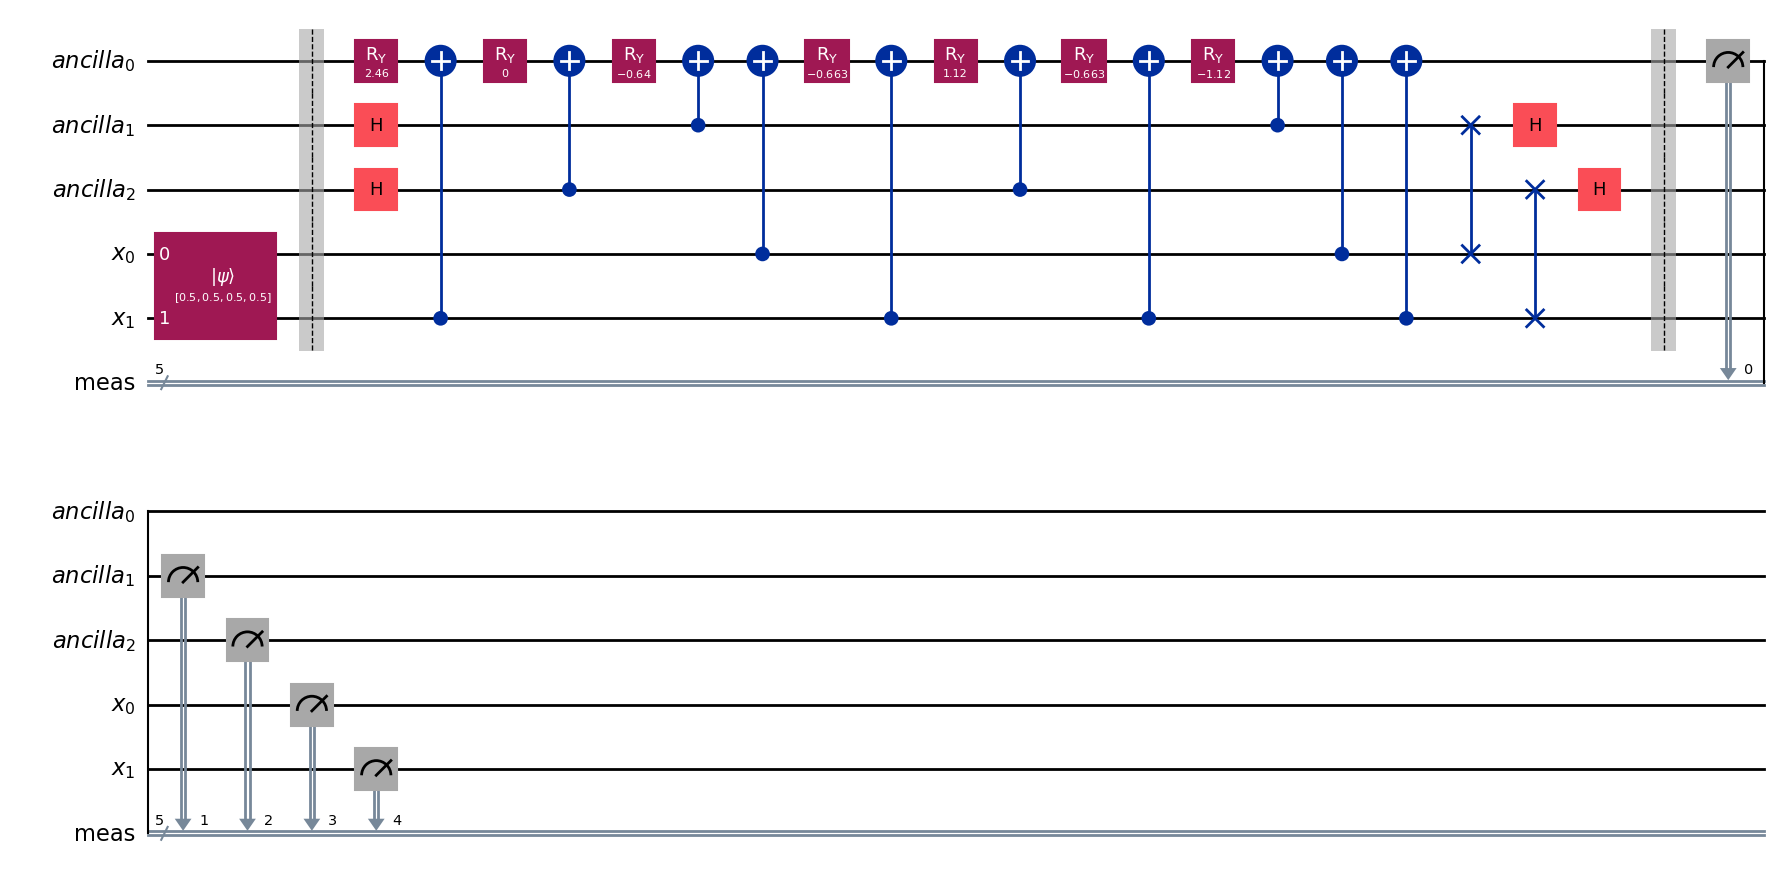

In [3]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector


# Create the various registers needed
ancilla_qubits = circ.num_qubits-n
ancilla = QuantumRegister(ancilla_qubits, name='ancilla')
input = QuantumRegister(n, name='x')


# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, input)
# initalize a state with [1 0 0 ... 0]
vector = []
for i in range(2**n):
    vector.append(1/np.sqrt(N))

v = Statevector(vector)
initial_state = vector/np.linalg.norm(vector)
circuit.initialize(initial_state, range(ancilla_qubits,ancilla_qubits+n))   

circuit.barrier()
circuit = circuit.compose(circ)
circuit.measure_all()

circuit.draw('mpl')

In [4]:
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
simulator = AerSimulator()
circuit_compiled = transpile(circuit, simulator, optimization_level=3)
tot_shots= 600000
job_sim = simulator.run(circuit_compiled, shots=tot_shots)
#Get the result of the execution
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit_compiled)

ancillas = '0'*ancilla_qubits
strings = []
for i in range(0,2**n):
    string = str(bin(i))[2:]
    string = string + ancillas
    lent = len(string)
    if lent < (n+ancilla_qubits):
        num_r = n+ancilla_qubits-lent
        string = '0'*num_r + string
    strings.append(string)

print(strings)
num_useful = 0
for string in strings:
    num_useful = num_useful + counts[string]

succ_prob=num_useful/tot_shots
print(succ_prob)

['00000', '01000', '10000', '11000']
0.061235
